In [1]:
import pytorch_lightning as pl
from PIL import Image

from pathlib import Path 
from typing import Union, Optional, Callable, List, Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torchmetrics
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from datetime import datetime
from importlib import reload
import torchvision

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [2]:
import src.models.train_model
#reload(src.models.train_model)

In [3]:
crop_to_lower_percentage = 50
resize_size = (500, 500)
output_size = (256, 256)
transform = transforms.Compose([
    src.models.train_model.CustomCropToLowerXPercent(crop_to_lower_percentage),
    transforms.Resize(700),  # get an image with height 700px
    transforms.CenterCrop((700, 1000)),  # get the center part with a HxW of 700x1000
    transforms.RandomCrop(500),  # get a 500x500px square
    transforms.Resize(output_size),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
data_dir = "/home/trossber/street-image-classification/data/raw"
ds = src.models.dataset.StreetImageDataset(path=data_dir,         
                   label_column="smoothness_category", 
                   #query="surface_category == 'paved'",
                   #query="smoothness_category == 'good'",
                   #label_column="surface_category",
                   transform=transform)
print(len(ds))

66715


In [6]:
num_workers = 20
batch_size = 64
train_loader, val_loader = src.models.train_model.create_train_val_loader(ds, 
                                                                            train_ratio=0.7,
                                                                            batch_size=batch_size,
                                                                            num_workers=num_workers)
train_loader.num_workers

20

# MTL ResNet Model 

In [7]:
from torchvision.models.utils import load_state_dict_from_url

In [8]:
class ResNet(nn.Module):

    def __init__(
        self,
        block,
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block, planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                torchvision.models.resnet.conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x1 = self.fc_task1(x)
        x2 = self.fc_task2(x)

        return x1, x2

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block,
    layers: List[int],
    pretrained:bool,
    progress: bool,
    **kwargs: Any
):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = torchvision.models.resnet.load_state_dict_from_url(torchvision.models.resnet.model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet('resnet18', torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)
def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet('resnet50', torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [9]:
def get_mtl_resnet50(num_classes: int):
    _m = resnet50(pretrained=True) #num_classes=3)
    _m.fc = nn.Sequential(nn.Flatten(),
                          nn.Linear(2048, 512),
                          nn.ReLU(), 
                          nn.Dropout(0.2))
    _m.fc_task1 = nn.Sequential(nn.Linear(512, num_classes), 
                                nn.LogSoftmax(dim=1))
    _m.fc_task2 = nn.Sequential(nn.Linear(512, num_classes),
                                nn.LogSoftmax(dim=1))
    return _m

In [22]:
_m = get_mtl_resnet50(3)

In [23]:
x1, x2 = _m(torch.Tensor(np.random.random((1, 3, 100, 100))))
print(x1, x2)

tensor([[-1.2300, -0.9608, -1.1235]], grad_fn=<LogSoftmaxBackward>) tensor([[-1.0930, -1.1406, -1.0638]], grad_fn=<LogSoftmaxBackward>)


/scratch/anaconda3/envs/torch-cargo3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [146]:
def _forward_impl_custom(self, x: torch.Tensor) -> torch.Tensor:
        pass
m = resnet50(pretrained=True)
m._forward_impl = _forward_impl_custom

# Mobilenet v3 (large)

| Model | Acc@1 | Acc@5 |
|---|---|---|
| MobileNet V2       | 71.878 | 90.286 | 
| MobileNet V3 Large | 74.042 | 91.340 | 
| MobileNet V3 Small | 67.668 | 87.402 | 

In [7]:
class MTL_MobileNetV3(torchvision.models.MobileNetV3):
    def __init__(self, inverted_residual_setting, last_channel):
        super().__init__(inverted_residual_setting, last_channel)
        arch = "mobilenet_v3_large"
        self.inverted_residual_setting = inverted_residual_setting
        self.last_channel = last_channel
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        self.lastconv_output_channels = 6 * lastconv_input_channels

    def add_mtl_head(self, num_classes=3):
        self.classifier =  nn.Sequential(
                nn.Linear(self.lastconv_output_channels, self.last_channel),
                nn.Hardswish(inplace=True),
                nn.Dropout(p=0.2, inplace=True))
        self.classifier1 = nn.Sequential(nn.Linear(self.last_channel, num_classes), 
                                         nn.LogSoftmax(dim=1))
        self.classifier2 = nn.Sequential(nn.Linear(self.last_channel, num_classes), 
                                         nn.LogSoftmax(dim=1))
        
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)
        x1 = self.classifier1(x)
        x2 = self.classifier2(x)
        return x1, x2

In [8]:
def my_mobilenet_v3_model(
    arch: str,
    inverted_residual_setting,
    last_channel: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
):
    model = MTL_MobileNetV3(inverted_residual_setting, last_channel)
    if pretrained:
        if torchvision.models.mobilenetv3.model_urls.get(arch, None) is None:
            raise ValueError("No checkpoint is available for model type {}".format(arch))
        state_dict = torchvision.models.mobilenetv3.load_state_dict_from_url(torchvision.models.mobilenetv3.model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

In [9]:
def mtl_mobilenet_v3_large(pretrained: bool = True, num_classes: int = 3):
    arch = "mobilenet_v3_large"
    inverted_residual_setting, last_channel = torchvision.models.mobilenetv3._mobilenet_v3_conf(arch)
    m = my_mobilenet_v3_model(arch, inverted_residual_setting, last_channel, pretrained, progress=True)
    m.add_mtl_head(num_classes=3)
    return m

In [16]:
m = mtl_mobilenet_v3_large(pretrained=True, num_classes=3)

In [17]:
x1, x2 = m(torch.Tensor(np.random.random((1, 3, 100, 100))))
print(x1, x2)

tensor([[-0.0337,  0.0108,  0.0853]], grad_fn=<AddmmBackward>) tensor([[-0.0209, -0.1206, -0.0302]], grad_fn=<AddmmBackward>)


# Training

In [10]:
def get_metric_dict(mode: str = "train", num_classes: int = 3) -> dict:
    kwargs = {"num_classes": num_classes, "average": "weighted"}
    metric_dict = {f"accuracy_{mode}_surface": torchmetrics.Accuracy(**kwargs),
                   f"precision_{mode}_surface": torchmetrics.Precision(**kwargs),
                   f"accuracy_{mode}_smoothness": torchmetrics.Accuracy(**kwargs),
                   f"precision_{mode}_smoothness": torchmetrics.Precision(**kwargs),
                   f"f1_{mode}_surface": torchmetrics.F1(**kwargs),
                   f"f1_{mode}_smoothness": torchmetrics.F1(**kwargs),
                  }
    return metric_dict

In [11]:
class CargoRocketModel(pl.LightningModule):

    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.num_classes = num_classes
        self.model = mtl_mobilenet_v3_large(pretrained=True, num_classes=self.num_classes)
        self.criterion1 = nn.NLLLoss()
        self.criterion2 = nn.NLLLoss()
        self.learning_rate = 1e-3
        
        self.train_metrics = get_metric_dict(mode="train", num_classes=self.num_classes)      
        self.val_metrics = get_metric_dict(mode="val", num_classes=self.num_classes)
        print("Using", self.num_classes, "classes")
       
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        prediction = self.model(x)
        return prediction

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x = batch["image"]
        y1 = batch["surface"]
        y2 = batch["smoothness"]

        y_hat1, y_hat2 = self.model(x)
        loss1 = self.criterion1(y_hat1, y1)
        loss2 = self.criterion2(y_hat2, y2)
        loss = loss1 + loss2
        self.log('train_loss', loss)

        for metric_name, metric in self.train_metrics.items():
            if "surface" in metric_name:
                metric(y_hat1.cpu(), y1.cpu())
                self.log(metric_name, metric, on_epoch=True)
            elif "smoothness" in metric_name:
                metric(y_hat2.cpu(), y2.cpu())
                self.log(metric_name, metric, on_epoch=True)

        
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y1 = batch["surface"]
        y2 = batch["smoothness"]

        y_hat1, y_hat2 = self.model(x)
        loss1 = self.criterion1(y_hat1, y1)
        loss2 = self.criterion2(y_hat2, y2)
        loss = loss1 + loss2
        self.log('val_loss', loss)
        
        for metric_name, metric in self.val_metrics.items():
            if "surface" in metric_name:
                metric(y_hat1.cpu(), y1.cpu())
                self.log(metric_name, metric, on_epoch=True, prog_bar=True)
            elif "smoothness" in metric_name:
                metric(preds=y_hat2.cpu(), target=y2.cpu())
                self.log(metric_name, metric, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [12]:
print("Cuda avail:", torch.cuda.is_available())

Cuda avail: True


In [16]:
torch.cuda.set_device("cuda:1")

In [17]:
model = CargoRocketModel(num_classes=3)

Using 3 classes


In [19]:
def get_checkpoint_callback(metric: str) -> ModelCheckpoint:
    callback = ModelCheckpoint(monitor=metric, 
                               mode="max",
                               filename='{epoch}-{val_loss:.2f}-{' + metric + ':.4f}')
    return callback

In [ ]:
checkpoint = "/home/trossber/street-image-classification/training_run_logs/lightning_logs/version_34/checkpoints/last.ckpt"
trainer = pl.Trainer(#gpus=1,
                     gpus=[1],
                     default_root_dir="/home/trossber/street-image-classification/training_run_logs/",
                     max_epochs=100,
                     callbacks=[ModelCheckpoint(save_last=True),
                              get_checkpoint_callback(metric="f1_val_surface"), 
                              get_checkpoint_callback(metric="f1_val_smoothness"), 
                              get_checkpoint_callback(metric="accuracy_val_surface"), 
                              get_checkpoint_callback(metric="accuracy_val_smoothness"), 
                               ],
                     #callbacks=[EarlyStopping(monitor='val_loss', patience=20)]
                     #resume_from_checkpoint=checkpoint
                    )
trainer.fit(model, train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type            | Params
-----------------------------------------------
0 | model      | MTL_MobileNetV3 | 4.2 M 
1 | criterion1 | NLLLoss         | 0     
2 | criterion2 | NLLLoss         | 0     
-----------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.839    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/scratch/anaconda3/envs/torch-cargo3/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Checkpoint loader

In [30]:
checkpoint_path = "/home/trossber/street-image-classification/training_run_logs/lightning_logs/version_51/checkpoints/"
checkpoint_path += "epoch=97-val_loss=0.93-f1_val_surface=0.9231.ckpt"
model_loaded = CargoRocketModel.load_from_checkpoint(checkpoint_path, num_classes=3)

x1, x2 = model_loaded(torch.Tensor(np.random.random((1, 3, 256, 256))))
print(x1, x2)

Using 3 classes
tensor([[-0.1754, -3.9359, -1.9565]], grad_fn=<LogSoftmaxBackward>) tensor([[-1.2401, -0.7259, -1.4839]], grad_fn=<LogSoftmaxBackward>)


# Broken img

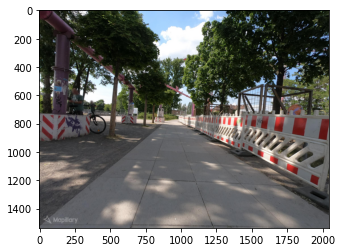

In [23]:
broken_img = "/home/trossber/street-image-classification/data/raw/images/rJN7Gii8NfYROj8P4t8WbY.jpg"
with Image.open(broken_img) as img:
    img_data = np.asarray(img)
plt.imshow(img_data)

# Predict for validation

In [81]:
val_batch = next(iter(val_loader))

In [84]:
x = val_batch["image"]
y1 = val_batch["surface"]
y2 = val_batch["smoothness"]
y_hat1, y_hat2 = model(x)

In [128]:
y_hat1.argmax(axis=1)

tensor([2, 1, 0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2, 1,
        0, 2, 0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 0, 0, 2, 2, 2, 1, 0, 2, 0, 0, 1, 2,
        0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 2, 1, 1])

In [130]:
y1

tensor([2, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 1,
        0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 0, 1, 2,
        1, 1, 0, 2, 0, 1, 0, 2, 0, 0, 2, 1, 0, 2, 1, 1])

In [123]:
tp /(tp+fp)

tensor(0.8438)

In [131]:
tp, fp, tn, fn, sup = torchmetrics.StatScores(num_classes=3)(y_hat1, y1)
torchmetrics.StatScores(num_classes=3)(y_hat1.argmax(axis=1), y1)
#  true positives, false positives, true negatives, false negatives
# TP, FP, TN, FN, sup

tensor([ 54,  10, 118,  10,  64])

In [142]:
torchmetrics.Accuracy(average="weighted", num_classes=3)(y_hat1, y1)

tensor(0.8438)

In [103]:
torchmetrics.ConfusionMatrix(num_classes=3)(y_hat1, y1)

tensor([[17.,  1.,  3.],
        [ 3., 18.,  1.],
        [ 2.,  0., 19.]])

In [98]:
sum(y_hat1.detach().numpy().argmax(axis=1) == y1.numpy()) / len(y1.numpy())

0.84375

In [95]:
for pred, true in zip(list(y_hat1.detach().numpy().argmax(axis=1)), list(y1.numpy())):
    print(pred, true)

2 2
1 1
0 0
2 2
2 2
0 2
0 0
0 0
0 0
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
0 0
2 2
2 2
0 1
2 2
1 1
0 0
2 1
0 1
1 1
1 1
0 0
2 2
2 0
2 2
1 0
1 1
1 1
0 0
0 0
2 2
2 0
2 2
1 1
0 0
2 2
0 0
0 0
1 1
2 2
0 1
1 1
0 0
0 2
0 0
1 1
0 0
2 2
0 0
0 0
2 2
1 1
2 0
2 2
1 1
1 1


In [11]:
next(iter(val_loader))

{'image': tensor([[[[276.0883, 263.5236, 261.9702,  ..., 469.8251, 472.7945, 474.5412],
           [337.2610, 317.8046, 319.4400,  ..., 468.0048, 462.7645, 457.3804],
           [364.0906, 347.6117, 333.8990,  ..., 448.4882, 453.7144, 457.7853],
           ...,
           [343.6022, 340.9358, 358.0522,  ..., 340.4449, 374.7145, 404.5305],
           [352.8575, 357.0562, 362.0213,  ..., 285.4120, 246.2015, 296.0220],
           [352.1953, 346.6461, 340.0551,  ..., 326.5631, 265.3203, 276.9417]],
 
          [[281.4257, 268.5805, 264.0094,  ..., 467.0489, 470.0845, 471.8702],
           [344.9186, 325.0279, 322.9054,  ..., 465.1879, 459.8307, 454.3264],
           [372.3471, 355.5003, 337.6870,  ..., 445.2357, 450.5786, 454.7403],
           ...,
           [351.4014, 348.6754, 364.9091,  ..., 346.7072, 378.7438, 406.7161],
           [360.8633, 365.1556, 370.1089,  ..., 291.7699, 251.3934, 302.3260],
           [360.1862, 354.5132, 347.7751,  ..., 333.9819, 271.3721, 283.2530]],
 
     

In [64]:
checkpoint_path = "/home/trossber/street-image-classification/training_run_logs/lightning_logs/version_23/checkpoints/last.ckpt"
model_trained = CargoRocketModel().load_from_checkpoint(checkpoint_path, num_classes=3).to("cuda:1")
model_trained.eval()

CargoRocketModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [73]:
df_preds = pd.DataFrame()

In [74]:
for batch in tqdm(val_loader):
    x = batch["image"].to(model_trained.device)
    label_surface = batch["surface"]
    label_smoothness = batch["smoothness"]
    image_path = batch["image_path"]
    preds_surface, preds_smoothness = model_trained(x)
    label_surface_pred = np.exp(preds_surface.detach().cpu().numpy()).argmax(axis=1)
    label_smoothness_pred = np.exp(preds_smoothness.detach().cpu().numpy()).argmax(axis=1)
    
    df_batch = pd.DataFrame({
    "image_id": [Path(i).stem for i in image_path],
    "surface_true": label_surface.numpy(),
    "smoothness_true": label_smoothness.numpy(),
    "surface_pred": label_surface_pred,
    "smoothness_pred": label_smoothness_pred,
    })
    df_preds = df_preds.append(df_batch)
    print(df_preds.shape)

  0%|          | 0/313 [00:00<?, ?it/s]

(64, 5)
(128, 5)
(192, 5)
(256, 5)
(320, 5)
(384, 5)
(448, 5)
(512, 5)
(576, 5)
(640, 5)
(704, 5)
(768, 5)
(832, 5)
(896, 5)
(960, 5)
(1024, 5)
(1088, 5)
(1152, 5)
(1216, 5)
(1280, 5)
(1344, 5)
(1408, 5)
(1472, 5)
(1536, 5)
(1600, 5)
(1664, 5)
(1728, 5)
(1792, 5)
(1856, 5)
(1920, 5)
(1984, 5)
(2048, 5)
(2112, 5)
(2176, 5)
(2240, 5)
(2304, 5)
(2368, 5)
(2432, 5)
(2496, 5)
(2560, 5)
(2624, 5)
(2688, 5)
(2752, 5)
(2816, 5)
(2880, 5)
(2944, 5)
(3008, 5)
(3072, 5)
(3136, 5)
(3200, 5)
(3264, 5)
(3328, 5)
(3392, 5)
(3456, 5)
(3520, 5)
(3584, 5)
(3648, 5)
(3712, 5)
(3776, 5)
(3840, 5)
(3904, 5)
(3968, 5)
(4032, 5)
(4096, 5)
(4160, 5)
(4224, 5)
(4288, 5)
(4352, 5)
(4416, 5)
(4480, 5)
(4544, 5)
(4608, 5)
(4672, 5)
(4736, 5)
(4800, 5)
(4864, 5)
(4928, 5)
(4992, 5)
(5056, 5)
(5120, 5)
(5184, 5)
(5248, 5)
(5312, 5)
(5376, 5)
(5440, 5)
(5504, 5)
(5568, 5)
(5632, 5)
(5696, 5)
(5760, 5)
(5824, 5)
(5888, 5)
(5952, 5)
(6016, 5)
(6080, 5)
(6144, 5)
(6208, 5)
(6272, 5)
(6336, 5)
(6400, 5)
(6464, 5)
(6528,

In [91]:
df_preds.to_csv("predictions_checkpoint_last.csv")

In [82]:
df_preds["surface_correct"] = df_preds["surface_true"] == df_preds["surface_pred"]
df_preds["smoothness_correct"] = df_preds["smoothness_true"] == df_preds["smoothness_pred"]

In [89]:
df_preds["smoothness_correct"].value_counts()

True     18021
False     1994
Name: smoothness_correct, dtype: int64

In [90]:
df_preds["surface_correct"].value_counts()

True     19049
False      966
Name: surface_correct, dtype: int64